Train words: 2433, Validation words: 1293
Valid keywords from train set: 35


Extracting features: 100%|██████████| 3726/3726 [00:23<00:00, 161.20it/s]


Extracted features: 3726


Evaluating keywords: 100%|██████████| 35/35 [2:36:27<00:00, 268.22s/it]  



Evaluated 35 keywords from training on validation set.
mAP: 0.3148

Top-5 keywords by AP:
  careful: 1.0000
  robert: 1.0000
  instructions: 0.8850
  major: 0.7500
  orders: 0.6852


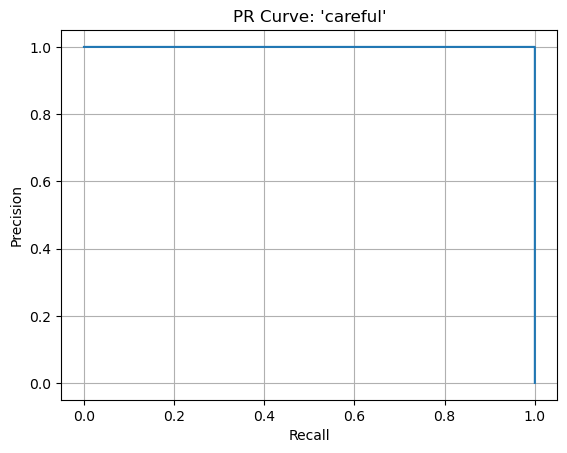

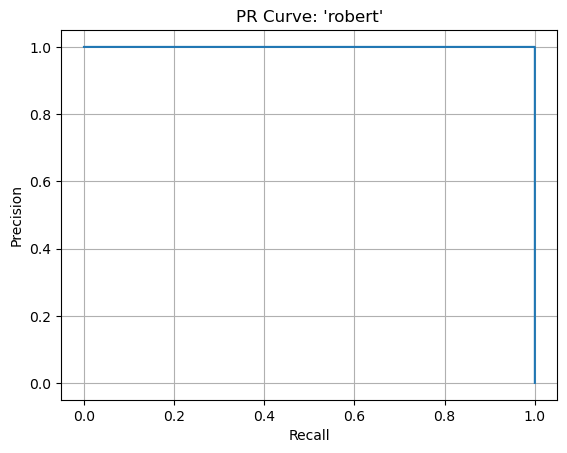

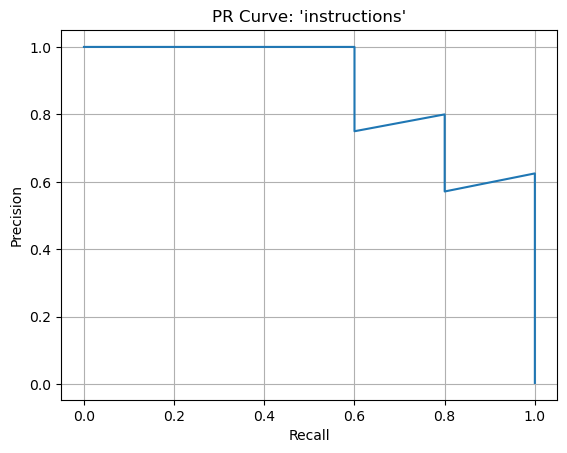

In [15]:
import os, re, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from tqdm import tqdm
from skimage import io
from joblib import Parallel, delayed

# feature and DTW
from features import extract_features
from dtw import dtw_distance

# dataloading
ROOT_DIR = "."
DATA_DIR = os.path.join(ROOT_DIR, "documents")
IMAGES_DIR = os.path.join(DATA_DIR, "original_images")
LOCATIONS_DIR = os.path.join(DATA_DIR, "ground-truth/locations")
WORD_IMAGES_DIR = os.path.join(DATA_DIR, "word_images")
TRANS_PATH = os.path.join(DATA_DIR, "transcription.tsv")
KEYWORDS_PATH = os.path.join(DATA_DIR, "keywords.tsv")
TRAIN_PATH = os.path.join(DATA_DIR, "train.tsv")
VALID_PATH = os.path.join(DATA_DIR, "validation.tsv")

os.makedirs(WORD_IMAGES_DIR, exist_ok=True)
trans_df = pd.read_csv(TRANS_PATH, sep="\t", names=["id", "transcription"], dtype={"id": str})
trans_df["doc_num"] = trans_df["id"].str.split("-", n=1, expand=True)[0].astype(int)
keywords_df = pd.read_csv(KEYWORDS_PATH, sep="\t", names=["keyword"])
train_ids = set(pd.read_csv(TRAIN_PATH, sep="\t", header=None)[0])
valid_ids = set(pd.read_csv(VALID_PATH, sep="\t", header=None)[0])

train_df = trans_df[trans_df["doc_num"].isin(train_ids)].copy()
valid_df = trans_df[trans_df["doc_num"].isin(valid_ids)].copy()

print(f"Train words: {len(train_df)}, Validation words: {len(valid_df)}")

# normalization
def normalize(s):
    s = re.sub(r's_[a-z0-9]+', '', s)
    s = s.replace("-", "").lower()
    return s

train_df["norm"] = train_df["transcription"].map(normalize)
valid_df["norm"] = valid_df["transcription"].map(normalize)
keywords_df["norm"] = keywords_df["keyword"].map(normalize)

# get the keywords from the training set so we can calculate btw with the validation wrapped word images
valid_keywords = []
for _, row in keywords_df.iterrows():
    kw = row["norm"]
    if kw in set(train_df["norm"]):
        valid_keywords.append(kw)
print(f"Valid keywords from train set: {len(valid_keywords)}")

# keywords for both traininig and validation 
keyword_train = {kw: train_df[train_df["norm"] == kw]["id"].tolist() for kw in valid_keywords}
keyword_valid = {kw: valid_df[valid_df["norm"] == kw]["id"].tolist() for kw in valid_keywords}

# features extraction
all_ids = list(train_df["id"]) + list(valid_df["id"])
feats = {}
for wid in tqdm(all_ids, desc="Extracting features"):
    path = os.path.join(WORD_IMAGES_DIR, f"{wid}.png")
    if os.path.exists(path):
        try:
            feats[wid] = extract_features(path)
        except:
            continue
print(f"Extracted features: {len(feats)}")

# keword spotting
from sklearn.metrics import average_precision_score, precision_recall_curve

# store all keyword DTW results
all_keyword_scores = {}

# parallel DTW scoring
def compute_dtw_pair(wid, query_feat, feats):
    return (wid, dtw_distance(query_feat, feats[wid]))

per_keyword_ap = {}
for kw in tqdm(valid_keywords, desc="Evaluating keywords"):
    train_ids_kw = keyword_train[kw]
    valid_ids_kw = keyword_valid[kw]
    if not train_ids_kw or not valid_ids_kw:
        continue
    query_id = train_ids_kw[0]
    if query_id not in feats: continue
    query_feat = feats[query_id]
    candidates = [wid for wid in valid_ids_kw if wid in feats]
    others = [wid for wid in valid_df["id"] if wid in feats]

    # ── Parallel DTW and store ───────────────────────────────────────────────
    scores = Parallel(n_jobs=-1, backend="loky")(delayed(compute_dtw_pair)(wid, query_feat, feats) for wid in others)
    scores.sort(key=lambda x: x[1])
    all_keyword_scores[kw] = scores  # store for reuse

    ranks = [wid for wid, _ in scores]
    y_true = np.array([1 if wid in candidates else 0 for wid in ranks])
    y_scores = -np.array([s for _, s in scores])
    if y_true.sum() == 0: continue
    ap = average_precision_score(y_true, y_scores)
    per_keyword_ap[kw] = ap

# report
print(f"\nEvaluated {len(per_keyword_ap)} keywords from training on validation set.")
print(f"mAP: {np.mean(list(per_keyword_ap.values())):.4f}")

# Show top 5
print("\nTop-5 keywords by AP:")
for kw, ap in sorted(per_keyword_ap.items(), key=lambda x: -x[1])[:5]:
    print(f"  {kw}: {ap:.4f}")

# PLots / reprt
for kw in sorted(per_keyword_ap, key=per_keyword_ap.get, reverse=True)[:3]:
    query_id = keyword_train[kw][0]
    query_feat = feats[query_id]
    valid_ids_kw = keyword_valid[kw]

    # reuse stored DTW results
    scores = all_keyword_scores[kw]
    ranks = [wid for wid, _ in scores]
    y_true = np.array([1 if wid in valid_ids_kw else 0 for wid in ranks])
    y_scores = -np.array([s for _, s in scores])
    p, r, _ = precision_recall_curve(y_true, y_scores)
    plt.figure()
    plt.plot(r, p, label=kw)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"PR Curve: '{kw}'")
    plt.grid(True)
    plt.show()


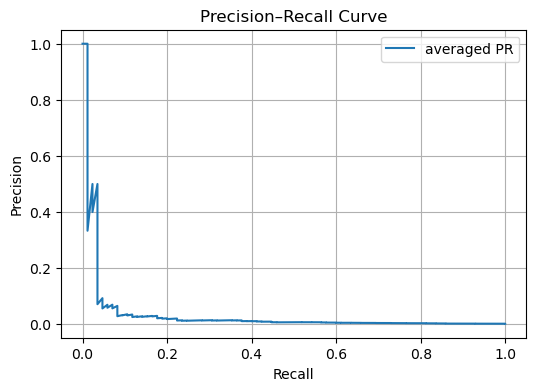

In [22]:
all_y_true = []
all_y_scores = []

for kw in valid_keywords:
    if kw not in all_keyword_scores:
        continue
    scores = all_keyword_scores[kw]
    valid_ids_kw = keyword_valid[kw]
    
    ranks = [wid for wid, _ in scores]
    y_true = [1 if wid in valid_ids_kw else 0 for wid in ranks]
    y_scores = [-s for _, s in scores]  # similarity = -distance

    all_y_true.extend(y_true)
    all_y_scores.extend(y_scores)

# Compute PR curve across all keywords
p, r, _ = precision_recall_curve(all_y_true, all_y_scores)

# Plot
plt.figure(figsize=(6, 4))
plt.plot(r, p, label="averaged PR")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.grid(True)
plt.legend()
plt.show()


In [ ]:
# loading test set
test_ids = set(pd.read_csv(os.path.join(DATA_DIR, "test.tsv"), header=None)[0])

# build test_word_ids from actual word_image filenames in pages 305–309
import glob
test_word_ids = []
for path in glob.glob(os.path.join(WORD_IMAGES_DIR, "*.png")):
    wid = os.path.splitext(os.path.basename(path))[0]
    doc = int(wid.split("-")[0])
    if doc in test_ids:
        test_word_ids.append(wid)
test_word_ids = sorted(test_word_ids)
print(f"Found {len(test_word_ids)} test words.")

# load the test‐keywords (query_id comes from your training set)
test_keywords_df = pd.read_csv(
    os.path.join(DATA_DIR, "keywordstest.tsv"), 
    sep="\t", names=["keyword","query_id"], dtype=str
)

# extracting features for queries + test words
query_ids = set(test_keywords_df["query_id"])
needed_ids = query_ids.union(test_word_ids)

feats = {}
for wid in tqdm(needed_ids, desc="Extracting features"):
    img_path = os.path.join(WORD_IMAGES_DIR, f"{wid}.png")
    if os.path.exists(img_path):
        try:
            feats[wid] = extract_features(img_path)
        except Exception as e:
            print(f"Skipping {wid}: {e}")

#  result save and calculations 
output_path = os.path.join(DATA_DIR, "test_output.tsv")
with open(output_path, "w") as f:
    for _, row in tqdm(test_keywords_df.iterrows(), total=len(test_keywords_df), desc="Generating predictions"):
        keyword, query_id = row["keyword"], row["query_id"]

        if query_id not in feats:
            print(f"Missing features for query {query_id}, skipping.")
            continue

        query_feat = feats[query_id]
        results = []
        for wid in test_word_ids:
            if wid not in feats:
                continue
            dist = dtw_distance(query_feat, feats[wid])
            results.append((wid, dist))

        # sort by increasing dissimilarity
        results.sort(key=lambda x: x[1])
        line = f"{keyword} " + " ".join(f"{wid} {dist:.6f}" for wid, dist in results)
        f.write(line + "\n")

print(f"\n Saved test predictions to: {output_path}")


Found 951 test words.


Generating predictions: 100%|██████████| 10/10 [41:15<00:00, 247.57s/it] 


✅ Saved test predictions to: .\documents\test_output.tsv


In [36]:
input_path = os.path.join(DATA_DIR, "test_output.tsv")
filtered_output_path = os.path.join(DATA_DIR, "test_output_filtered.tsv")
top_k = 8   # change this to whatever number of top results you want

with open(input_path, "r") as infile, open(filtered_output_path, "w") as outfile:
    for line in infile:
        parts = line.strip().split()
        if len(parts) < 3:
            continue  
        keyword = parts[0]
        pairs = parts[1:]

        # parse the wid-dist pairs
        wid_dist_pairs = []
        for i in range(0, len(pairs), 2):
            wid = pairs[i]
            dist = float(pairs[i + 1])
            wid_dist_pairs.append((wid, dist))

        # sort by distance and keep top K
        wid_dist_pairs.sort(key=lambda x: x[1])
        top_k_pairs = wid_dist_pairs[:top_k]

        # format output
        if top_k_pairs:
            line_out = f"{keyword} " + " ".join(f"{wid} {dist:.6f}" for wid, dist in top_k_pairs)
            outfile.write(line_out + "\n")

print(f"\n Top-{top_k} filtered predictions saved to: {filtered_output_path}")



 Top-8 filtered predictions saved to: .\documents\test_output_filtered.tsv
